# **0. Importing Libraries**


In [1]:
pip install torch==1.11.0

     |████████████████████████████████| 43.1 MB 13.5 MB/s eta 0:00:01   |██████▊                         | 9.1 MB 3.6 MB/s eta 0:00:10     |██████████                      | 13.5 MB 3.6 MB/s eta 0:00:09               | 22.1 MB 13.2 MB/s eta 0:00:02�████████████████████▎      | 34.0 MB 13.6 MB/s eta 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1
    Uninstalling torch-1.12.1:
      Successfully uninstalled torch-1.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
open-clip-torch 2.7.0 requires protobuf==3.20.0, but you have protobuf 3.19.6 which is incompatible.
clean-fid 0.1.29 requires requests==2.25.1, but you have requests 2.28.2 which is incompatible.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.
Note: you may need to res

In [2]:
pip install torchvision==0.12.0

     |████████████████████████████████| 1.2 MB 3.9 MB/s eta 0:00:01
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.1
    Uninstalling torchvision-0.13.1:
      Successfully uninstalled torchvision-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
open-clip-torch 2.7.0 requires protobuf==3.20.0, but you have protobuf 3.19.6 which is incompatible.
clean-fid 0.1.29 requires requests==2.25.1, but you have requests 2.28.2 which is incompatible.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [12]:
!pip3 install mlxtend

     |████████████████████████████████| 1.4 MB 5.6 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.


In [40]:
!pip3 install torchsummary

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.


In [41]:
import numpy as np
import pandas as pd

import os
import random
from operator import itemgetter
import copy
import time

import torch
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.transforms as transform
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.nn as nn
import torchvision.models as models
from torchvision.utils import make_grid
import torch.nn.functional as F
from torchsummary import summary

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import seaborn as sns

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


import multiprocessing
NUM_CORES = multiprocessing.cpu_count()

# **1. Reading data**

**Data path**

In [2]:
!ls ../dataset-resized


cardboard  counter.sh glass      metal      paper      plastic    trash


In [3]:
example = '../dataset-resized/glass/glass1.jpg'
path = '../dataset-resized'

Shape: (384, 512, 3)


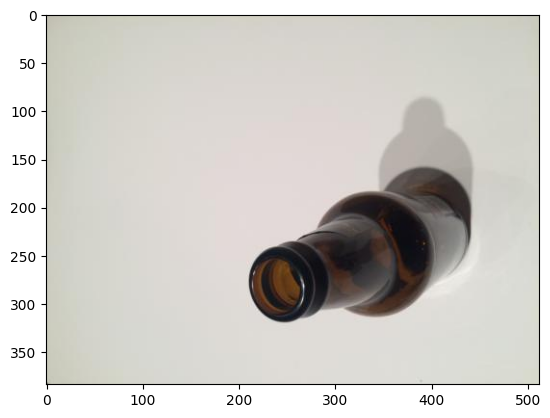

In [4]:
img = mpimg.imread(example)
print('Shape:', img.shape)
plt.imshow(img);

**Grayscale pixel intensity histogram**

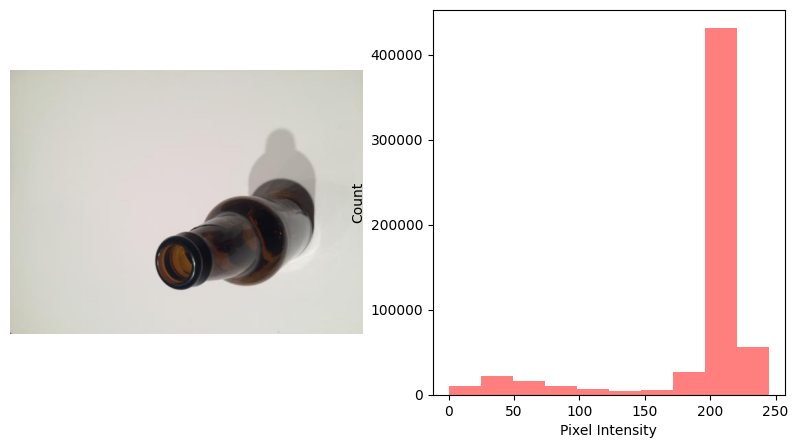

In [5]:
def plotHist(img):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.imshow(img)
  plt.axis('off')
  histo = plt.subplot(1,2,2)
  histo.set_ylabel('Count')
  histo.set_xlabel('Pixel Intensity')
  plt.hist(img.flatten(), bins=10, lw=0, alpha=0.5, color='r')

plotHist(img)

# **2. Data Augmentation**


In [6]:
transformer = {
    'original': transform.Compose([
        transform.Resize((224, 224)),
        transform.ToTensor(), 
        transform.Normalize((0.485, 0.456, 0.406),(0.229,0.224,0.225))
]), 
   'dataset1': transform.Compose([
       transform.Resize((224, 224)),
       #Random image brightness, contrast, saturation
       transform.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
       #Random flip
       transform.RandomRotation(5),
       #Random radiation variation
       transform.RandomAffine(degrees=11, translate=(0.1,0.1), scale=(0.8,0.8)),
       transform.ToTensor(),
       transform.Normalize((0.485, 0.456, 0.406),(0.229,0.224,0.225))
])
}

**20% train-test split**

In [8]:
bs = 64

original = ImageFolder(path, transform=transformer['original'])

#all_set = train_val + test
train_val, test = train_test_split(original, test_size=0.2, shuffle=True, random_state=43)

#train_val = train + val + dataset1 + dataset2 + dataset3
train_val = ConcatDataset([train_val, 
                           ImageFolder(path, transform=transformer['dataset1'])]) 

train, val = train_test_split(train_val, test_size=0.1, shuffle=True, random_state=43)

loaders = {
    'train': DataLoader(train, batch_size=bs, num_workers=NUM_CORES, pin_memory=False),
    'val': DataLoader(val, batch_size=bs, num_workers=NUM_CORES, pin_memory=False),
    'test': DataLoader(test, batch_size=bs, num_workers=NUM_CORES, pin_memory=False)
}

dataset_sizes = {
    'train': len(train),
    'val': len(val), 
    'test': len(test),
}

**Normalize each channel in preparation for normalization (normalization) processing**

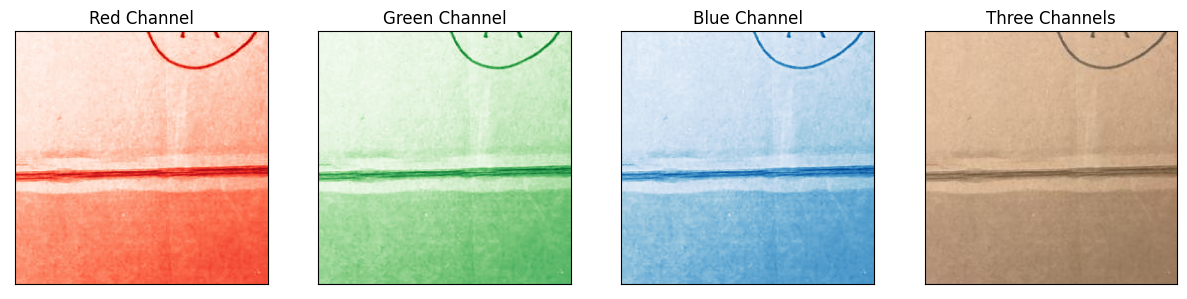

In [9]:
exampleset = ImageFolder(path, transform=transform.Compose([transform.ToTensor(),
                                                            transform.CenterCrop(255),]))

x, y = next(iter(DataLoader(exampleset)))

channels = ['Red', 'Green', 'Blue']
cmaps = [plt.cm.Reds_r, plt.cm.Greens_r, plt.cm.Blues_r]

fig, ax = plt.subplots(1, 4, figsize=(15, 10))

for i, axs in enumerate(fig.axes[:3]):
    axs.imshow(x[0][i,:,:], cmap=cmaps[i])
    axs.set_title(f'{channels[i]} Channel')
    axs.set_xticks([])
    axs.set_yticks([])
    
ax[3].imshow(x[0].permute(1,2,0))
ax[3].set_title('Three Channels')
ax[3].set_xticks([])
ax[3].set_yticks([]);

**Calculate variance and standard deviation for each channel**

In [10]:
channels = 3

for channel in range(channels):
    for x in ['train', 'val', 'test']:
        #number of pixels in the dataset = number of all pixels in one object * number of all objects in the dataset
        num_pxl = dataset_sizes[x]*220*220
    
        #we go through the butches and sum up the pixels of the objects, 
        #which then divide the sum by the number of all pixels to calculate the average
        total_sum = 0
        for batch in loaders[x]:
            layer = list(map(itemgetter(channel), batch[0]))
            layer = torch.stack(layer, dim=0)
            total_sum += layer.sum()
        mean = total_sum / num_pxl

        #we calculate the standard deviation using the formula that I indicated above
        sum_sqrt = 0
        for batch in loaders[x]: 
            layer = list(map(itemgetter(channel), batch[0]))
            sum_sqrt += ((torch.stack(layer, dim=0) - mean).pow(2)).sum()
        std = torch.sqrt(sum_sqrt / num_pxl)
        
        print(f'|channel:{channel+1}| {x} - mean: {mean}, std: {std}')

|channel:1| train - mean: 0.19731807708740234, std: 1.4692825078964233
|channel:1| val - mean: 0.2259940803050995, std: 1.4637203216552734
|channel:1| test - mean: 0.858325719833374, std: 0.9165021181106567
|channel:2| train - mean: 0.21469420194625854, std: 1.4548934698104858
|channel:2| val - mean: 0.2523711919784546, std: 1.4553210735321045
|channel:2| test - mean: 0.8631836771965027, std: 0.945665180683136
|channel:3| train - mean: 0.31348204612731934, std: 1.4484459161758423
|channel:3| val - mean: 0.36250361800193787, std: 1.4529392719268799
|channel:3| test - mean: 0.932144820690155, std: 1.045007348060608


In [11]:
x, y = next(iter(loaders['train']))
x.mean(),  x.std()

(tensor(0.4058), tensor(1.4374))

**By normalizing the image and its grayscale histogram**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


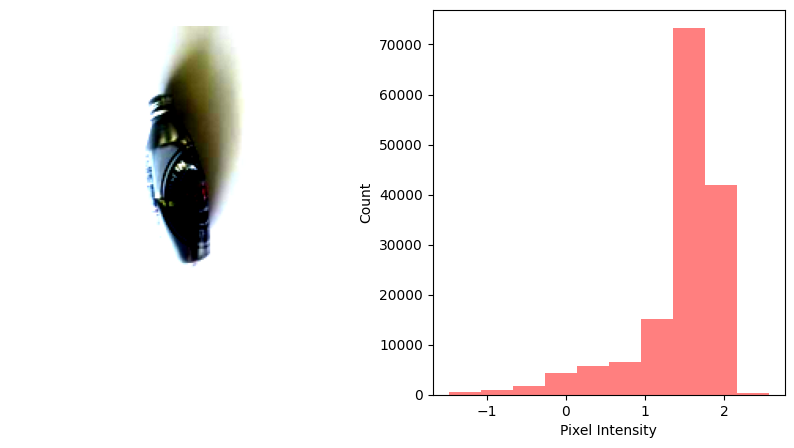

In [12]:
x, y = next(iter(loaders['train']))
img_norm = x[0].permute(1,2,0).numpy()
plotHist(img_norm)

**Dataset Cateogries**

In [13]:
print('Classes:', original.classes)
print('Number of classes:', len(original.classes))

Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Number of classes: 6


In [14]:
dic = {}

for classes in original.classes:
  dic[classes] = [len([os.path.join(path+'/'+classes, filename) for filename in os.listdir(path+'/'+classes)])]

samplesize = pd.DataFrame.from_dict(dic)

In [15]:
samplesize

cardboard  glass  metal  paper  plastic  trash
0        403    501    410    594      482    137

**Basic EDA: data distribution**

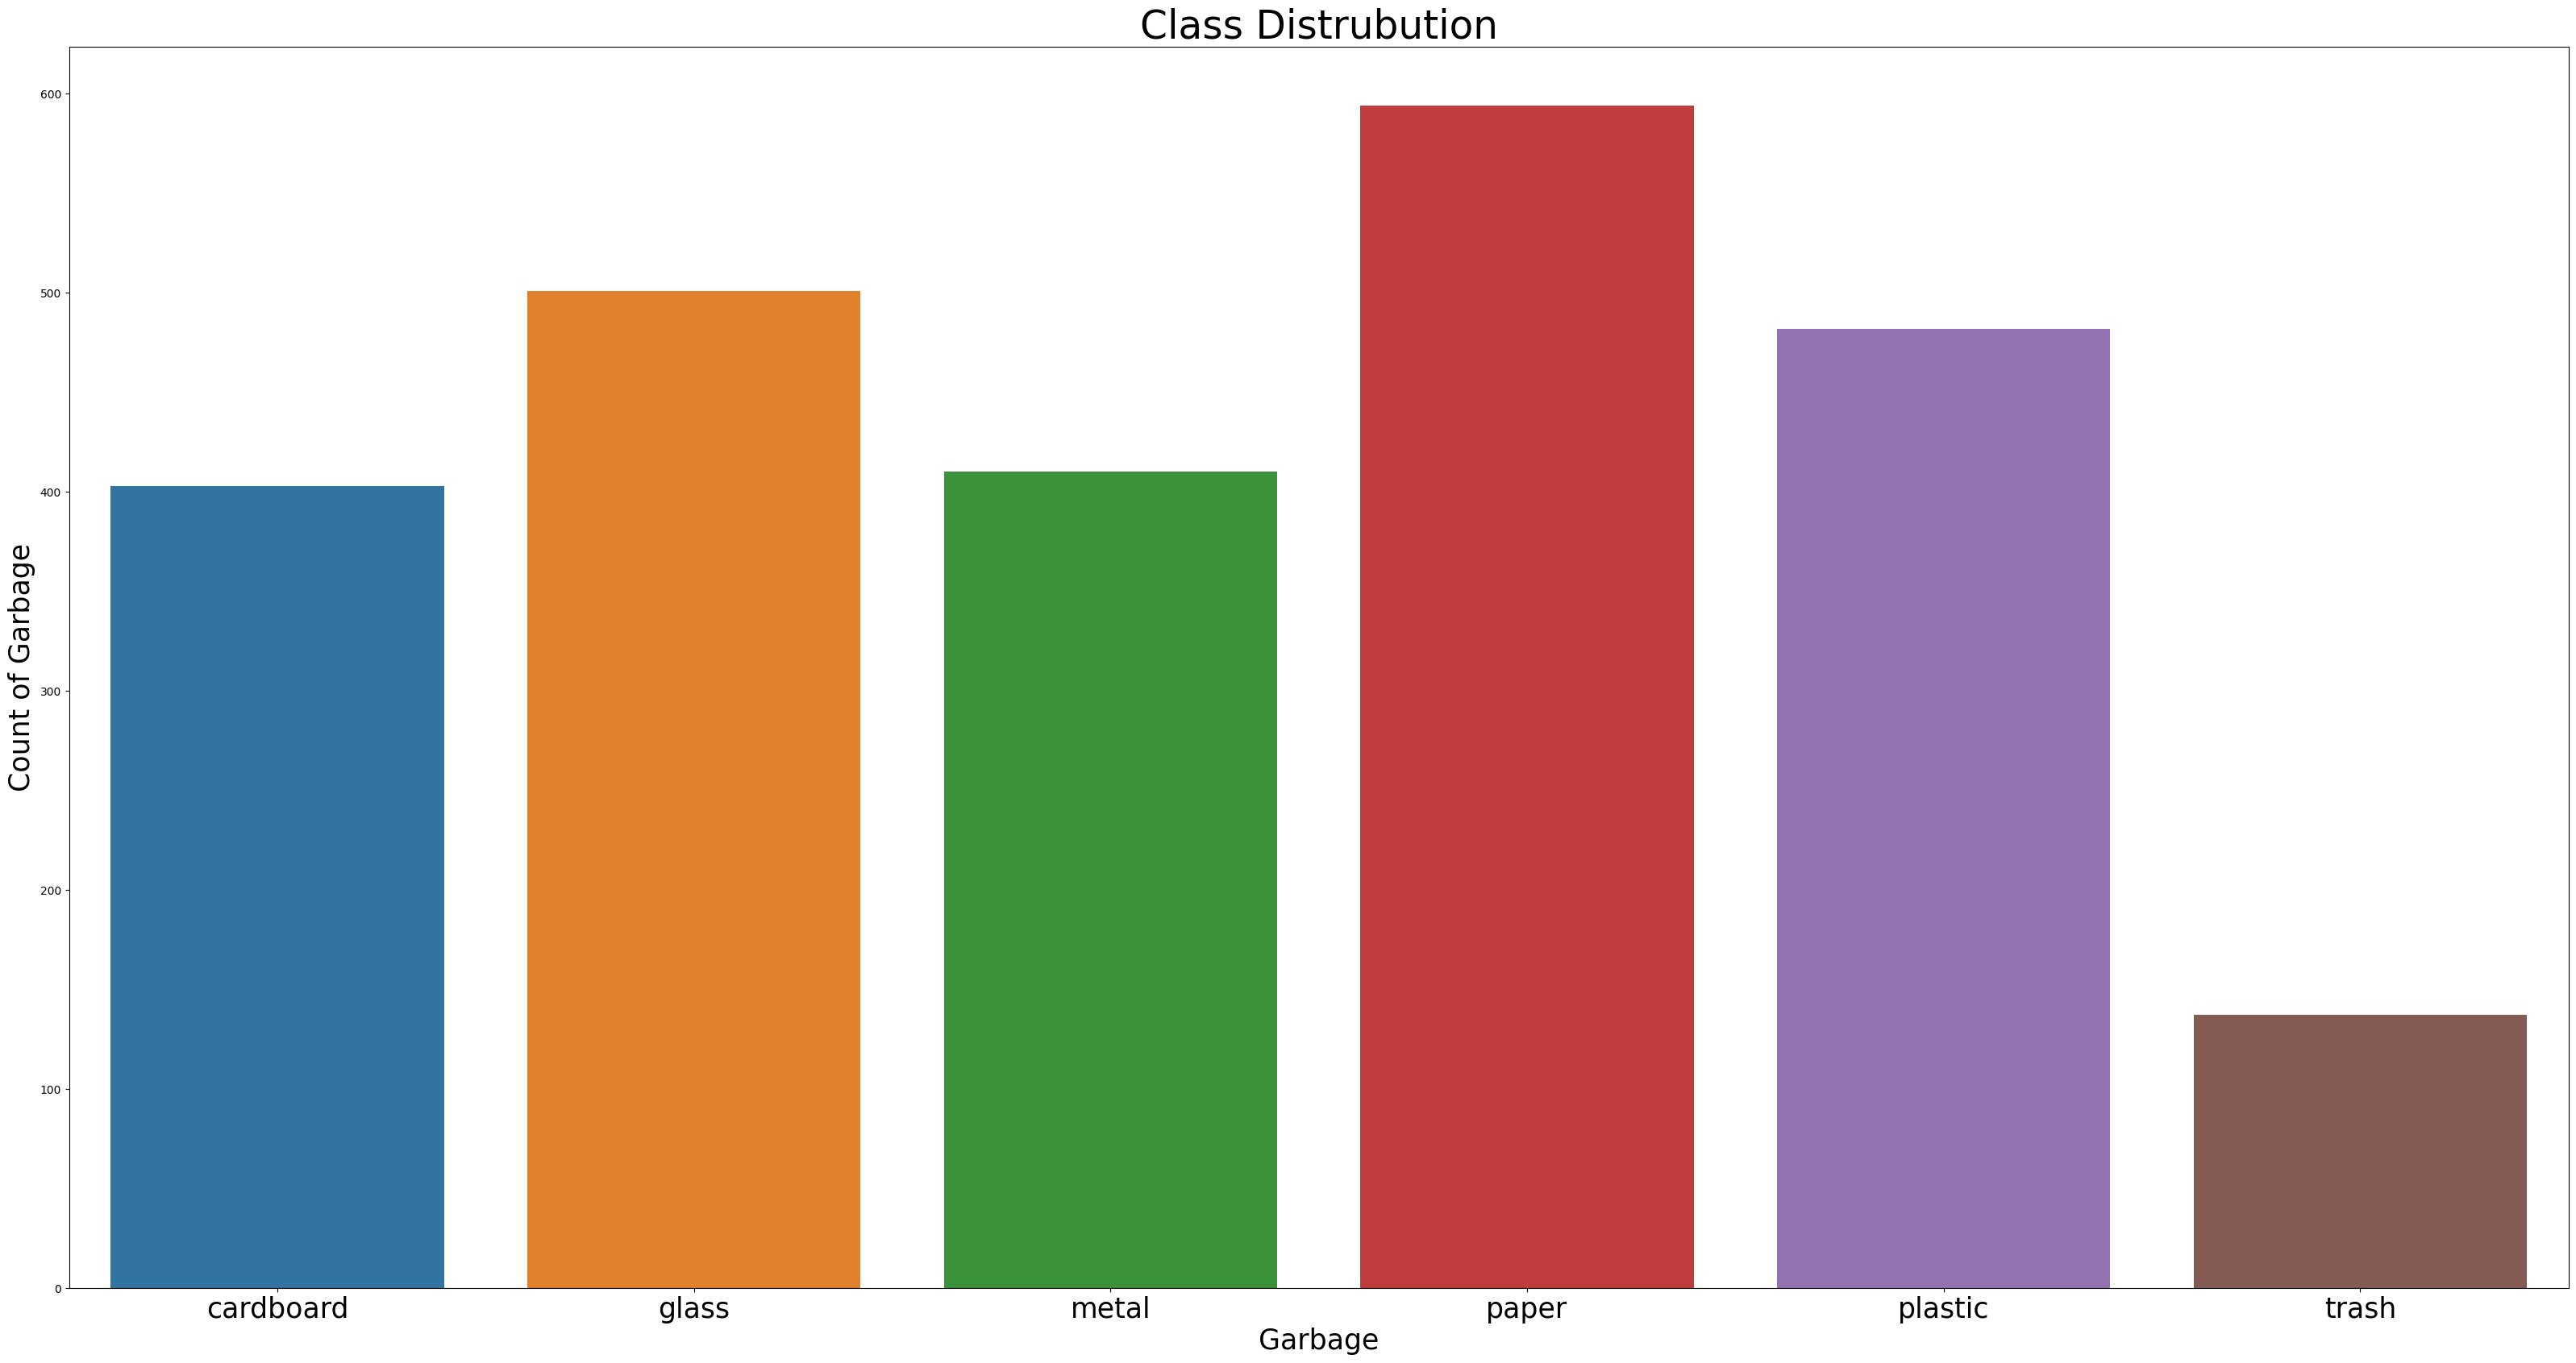

In [16]:
figure_size = plt.rcParams['figure.figsize']
figure_size[0] = 40
figure_size[1] = 20
plt.rcParams['figure.figsize'] = figure_size

sns.barplot(data=samplesize)

index = np.arange(len(original.classes))

plt.xlabel('Garbage', fontsize=25)
plt.ylabel('Count of Garbage', fontsize=25)
plt.xticks(index, original.classes, fontsize=25)
plt.title('Class Distrubution', fontsize=35)
plt.show()

**Example Images of the normalized image:**

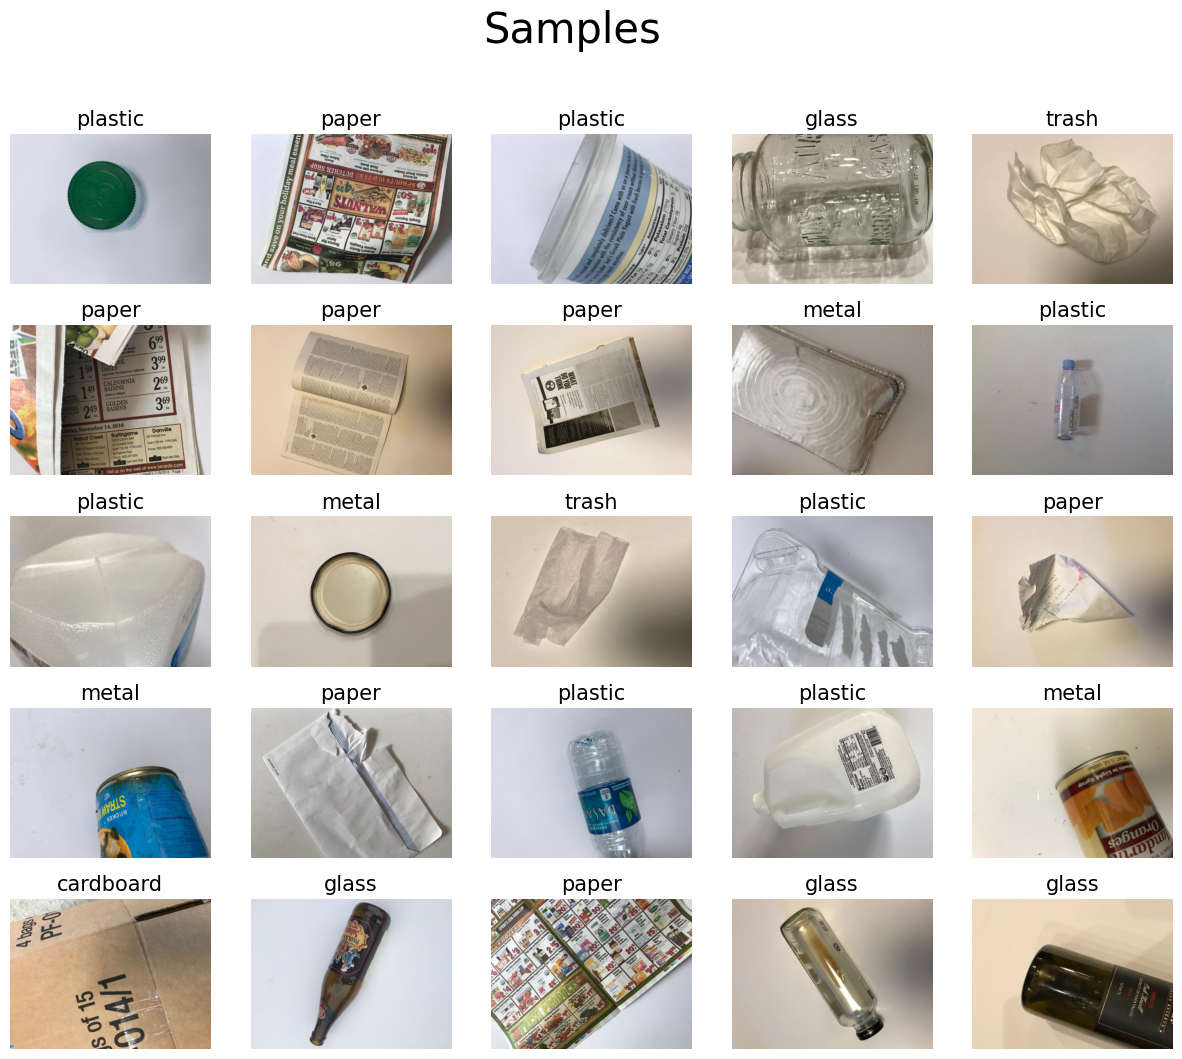

In [17]:
# Function for plotting samples
def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,12))
    i = 0
    for row in range(5):
         for col in range(5):
                img = mpimg.imread(samples[i][0][0])
                ax[row][col].imshow(img)
                ax[row][col].axis('off')
                ax[row][col].set_title(samples[i][1], fontsize=15)
                i+=1
  

rand_samples = [] 
for _ in range(25): 
    classes = random.choice(original.classes)
    rand_samples.append([random.sample([os.path.join(path+'/'+classes, filename) for filename in os.listdir(path+'/'+classes)], 1), classes]) 
rand_samples[0]
plot_samples(rand_samples)
plt.suptitle('Samples', fontsize=30)
plt.show()

**Example Images after data augmentation**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


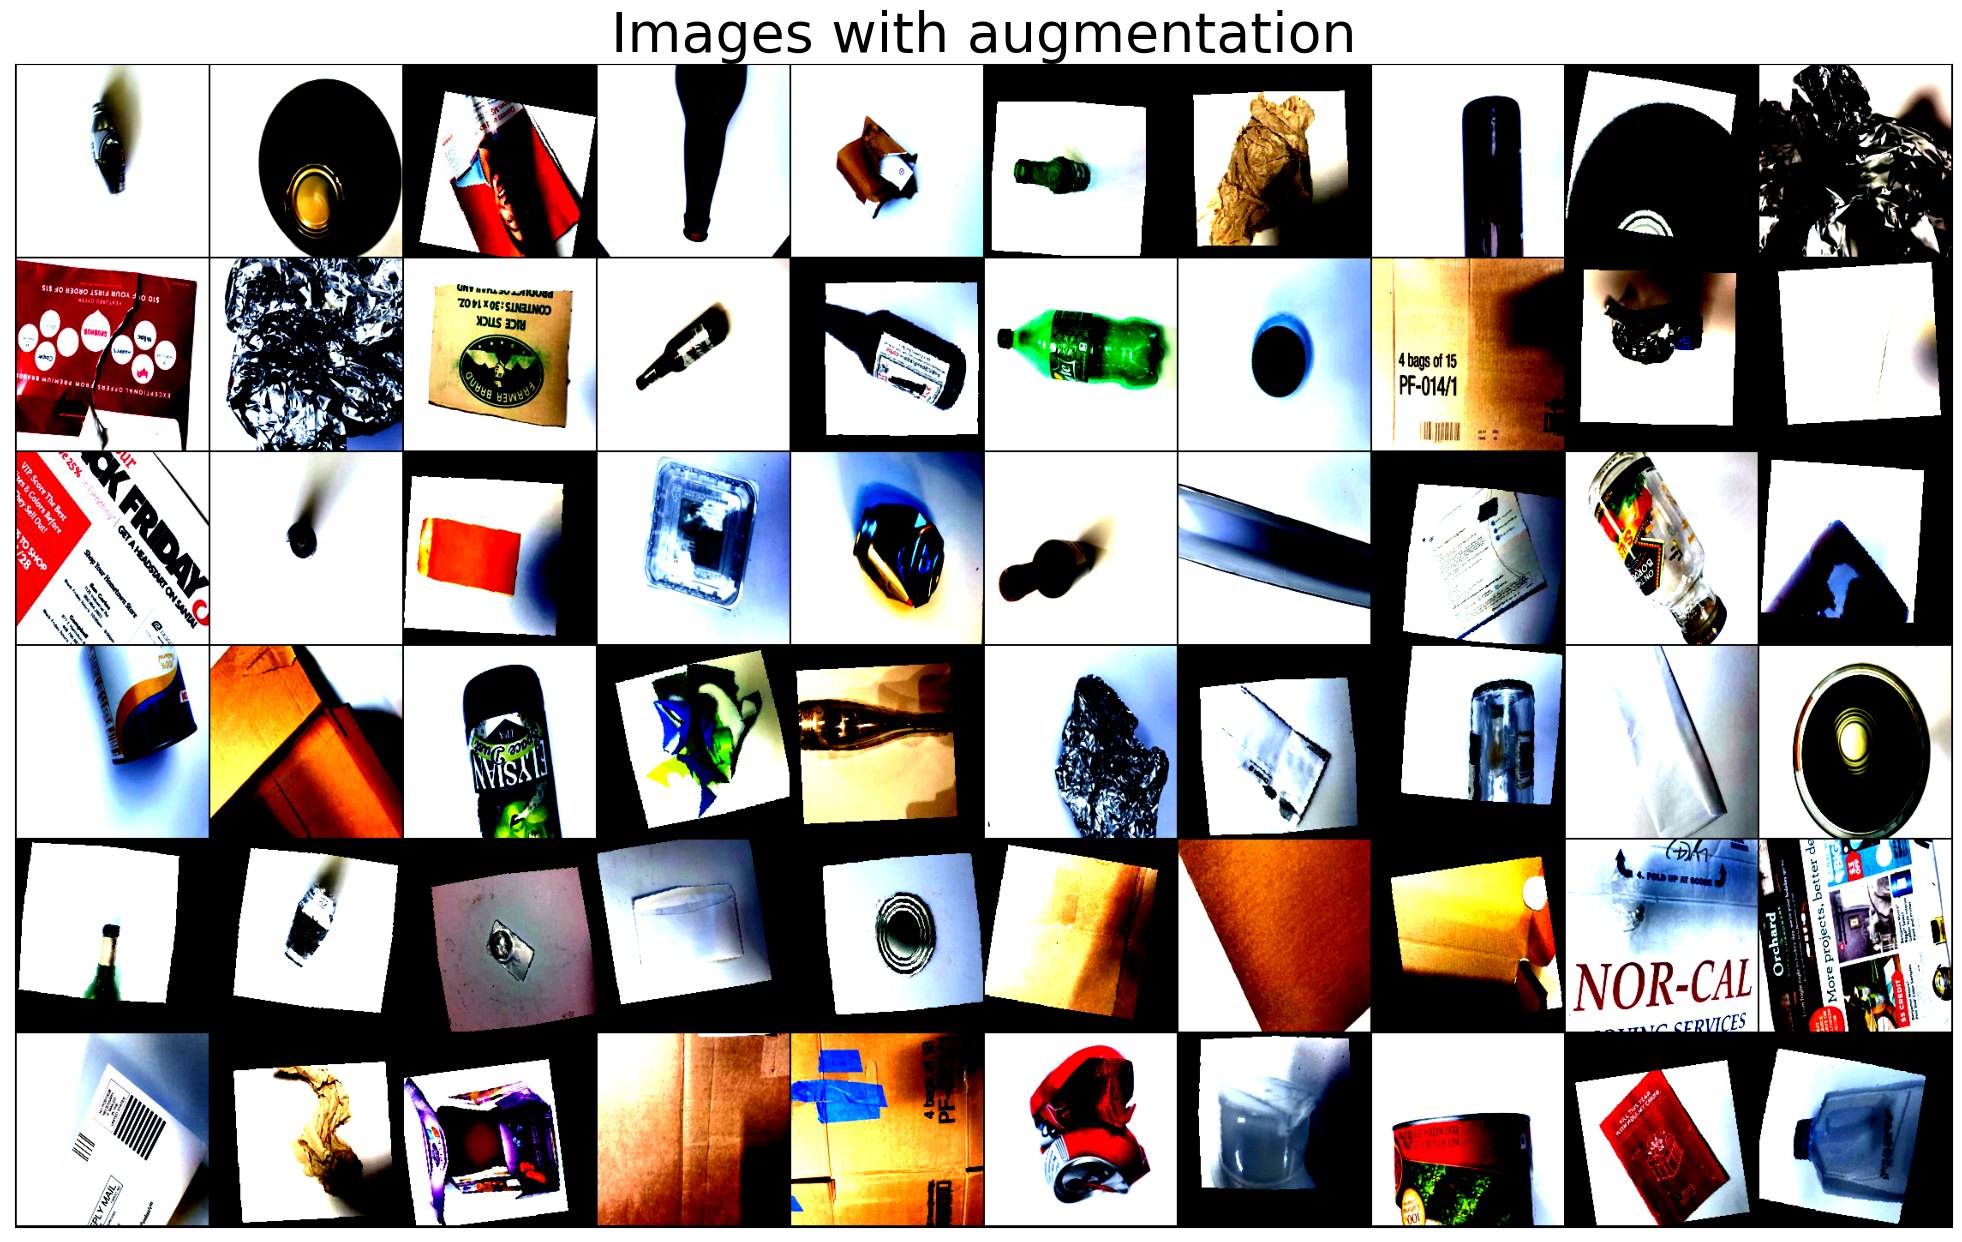

In [18]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(25, 25))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
        ax.set_title('Images with augmentation', fontsize=40)
        break
        
show_batch(loaders['train'])

# 3. Train and Test


**Using a set of pretrained models, we'll first train the classifier on 10 epochs, then unfreeze the network and traing another 10 epochs**

**Define Accuracy**

In [19]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

**Keep track of losses and accuracies for visualizations later**

In [20]:
#save the losses for further visualization
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
lr = []

Define the training function:

In [21]:
def train(seed, epochs, model):
    
  print('Creating a model {}...'.format(seed))

  model.to(device)  
  criterion = nn.CrossEntropyLoss()
  if seed==2:
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay = 1e-5)
  else:
    optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)
  #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.1, epochs=epochs, steps_per_epoch=len(loaders['train']), cycle_momentum=True)
  #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, gamma=0.1)
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  print("Optimizer: ", optimizer)
  print("Scheduler: ", scheduler)
  print('Starting training...')
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
#             lr.append(scheduler.get_lr())
#             scheduler.step()

        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)

      if phase == 'train':
          acc = 100. * running_corrects.double() / dataset_sizes[phase]
          scheduler.step(acc)

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
      lr.append(scheduler._last_lr)
        
      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
        print('=='*31)
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    #scheduler.step() 
  time_elapsed = time.time() - since
  print('CLASSIFIER TRAINING TIME {}m {}s'.format(time_elapsed//60, time_elapsed%60))
  print('=='*31)


  model.load_state_dict(best_model)

  for param in model.parameters():
        param.requires_grad=True

  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)  
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2, verbose=True)
  #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, gamma=0.1)
  #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.001, epochs=epochs, steps_per_epoch=len(loaders['train']), cycle_momentum=True)
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
#             lr.append(scheduler.get_lr())
#             scheduler.step()

        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)

      if phase == 'train':
        acc = 100. * running_corrects.double() / dataset_sizes[phase]
        scheduler.step(acc)

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
      lr.append(scheduler._last_lr)
    
      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
        print('=='*31)    
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    #scheduler.step() 
  time_elapsed = time.time() - since
  print('ALL NET TRAINING TIME {}m {}s'.format(time_elapsed//60, time_elapsed%60))
  print('=='*31)

  model.load_state_dict(best_model)
  return model

# Model

**1. DenseNet(1)**

In [22]:
densenet121_0 = torchvision.models.densenet121(pretrained=True)
for param in densenet121_0.parameters():
  param.requires_grad=False

densenet121_0.classifier = nn.Linear(in_features=densenet121_0.classifier.in_features, out_features=len(original.classes), bias=True)

**3. Convnext**

In [23]:
convnext = torchvision.models.convnext_tiny (pretrained=True)
for param in convnext.parameters():
  param.grad_requires = False
convnext.classifier[2] = nn.Linear(in_features=768,out_features=6, bias=True)

**4. ResNet**

In [24]:
resnet101 = torchvision.models.resnet101(pretrained=True)
for param in resnet101.parameters():
  param.grad_requires = False

resnet101.fc = nn.Linear(in_features=resnet101.fc.in_features, out_features=len(original.classes), bias=True)

**Call and Start training**

In [25]:
num_models = 3
epochs = 10

# models = [densenet121_0, densenet121_1, googlenet, resnet101, vgg19_bn]
models = [convnext, densenet121_0,resnet101]

for seed in range(num_models):
   train(seed=seed, epochs=epochs, model=models[seed])

Creating a model 0...
Optimizer:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Scheduler:  <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x382c89d20>
Starting training...
Epoch: 1/10
train - loss:0.846563193767775, accuracy0.729293916442707
val - loss:0.46580148738819166, accuracy0.8615384615384616
Time: 13.0m 17.983309030532837s
Epoch: 2/10
train - loss:0.41853384109659475, accuracy0.8739311018812607
val - loss:0.36504127889216603, accuracy0.8967032967032967
Time: 26.0m 29.631016969680786s
Epoch: 3/10
train - loss:0.3378554476944299, accuracy0.8937209870510628
val - loss:0.3187572892796207, accuracy0.9032967032967033
Time: 39.0m 37.14119815826416s
Epoch: 4/10
train - loss:0.28456706475969806, accuracy0.9137551917908624
val - loss:0.2883189500770071, accuracy0.9164835164835164
Time: 53.0m 56.63092923164368s
Epoch: 5/10
train - loss:0.2522640076492982, accuracy0.9230393354507697
val - l

Epoch: 3/10
train - loss:0.007564932009855532, accuracy0.9990227217200097
val - loss:0.10166267114998466, accuracy0.9714285714285714
Time: 41.0m 38.66906118392944s
Epoch 00004: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 4/10
train - loss:0.004279677067650539, accuracy0.9990227217200097
val - loss:0.10094411467447631, accuracy0.9714285714285714
Time: 47.0m 33.44234609603882s
Epoch: 5/10
train - loss:0.002436066287777446, accuracy0.9997556804300024
val - loss:0.10439590640202329, accuracy0.9714285714285714
Time: 53.0m 28.485493183135986s
Epoch: 6/10
train - loss:0.0022601765331773747, accuracy1.0
val - loss:0.10434817116308426, accuracy0.9714285714285714
Time: 59.0m 23.228005170822144s
Epoch 00007: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 7/10
train - loss:0.002123838762718353, accuracy1.0
val - loss:0.10430319001744655, accuracy0.9714285714285714
Time: 65.0m 18.839906215667725s
Epoch: 8/10
train - loss:0.002029709865921831, accuracy1.0
val - loss:0.1042753447

# 4. Model Summary + Training and Loss Visualization

In [71]:
print("convnext")
summary(convnext, input_size=(3, 384, 512))

convnext
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 96, 96, 128]           4,704
       LayerNorm2d-2          [-1, 96, 96, 128]             192
            Conv2d-3          [-1, 96, 96, 128]           4,800
           Permute-4          [-1, 96, 128, 96]               0
         LayerNorm-5          [-1, 96, 128, 96]             192
            Linear-6         [-1, 96, 128, 384]          37,248
              GELU-7         [-1, 96, 128, 384]               0
            Linear-8          [-1, 96, 128, 96]          36,960
           Permute-9          [-1, 96, 96, 128]               0
  StochasticDepth-10          [-1, 96, 96, 128]               0
          CNBlock-11          [-1, 96, 96, 128]               0
           Conv2d-12          [-1, 96, 96, 128]           4,800
          Permute-13          [-1, 96, 128, 96]               0
        LayerNorm-14          

In [72]:
print("resnet101")
summary(resnet101, input_size=(3, 384, 512))

resnet101
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 192, 256]           9,408
       BatchNorm2d-2         [-1, 64, 192, 256]             128
              ReLU-3         [-1, 64, 192, 256]               0
         MaxPool2d-4          [-1, 64, 96, 128]               0
            Conv2d-5          [-1, 64, 96, 128]           4,096
       BatchNorm2d-6          [-1, 64, 96, 128]             128
              ReLU-7          [-1, 64, 96, 128]               0
            Conv2d-8          [-1, 64, 96, 128]          36,864
       BatchNorm2d-9          [-1, 64, 96, 128]             128
             ReLU-10          [-1, 64, 96, 128]               0
           Conv2d-11         [-1, 256, 96, 128]          16,384
      BatchNorm2d-12         [-1, 256, 96, 128]             512
           Conv2d-13         [-1, 256, 96, 128]          16,384
      BatchNorm2d-14         

**Comparison of Different Models**

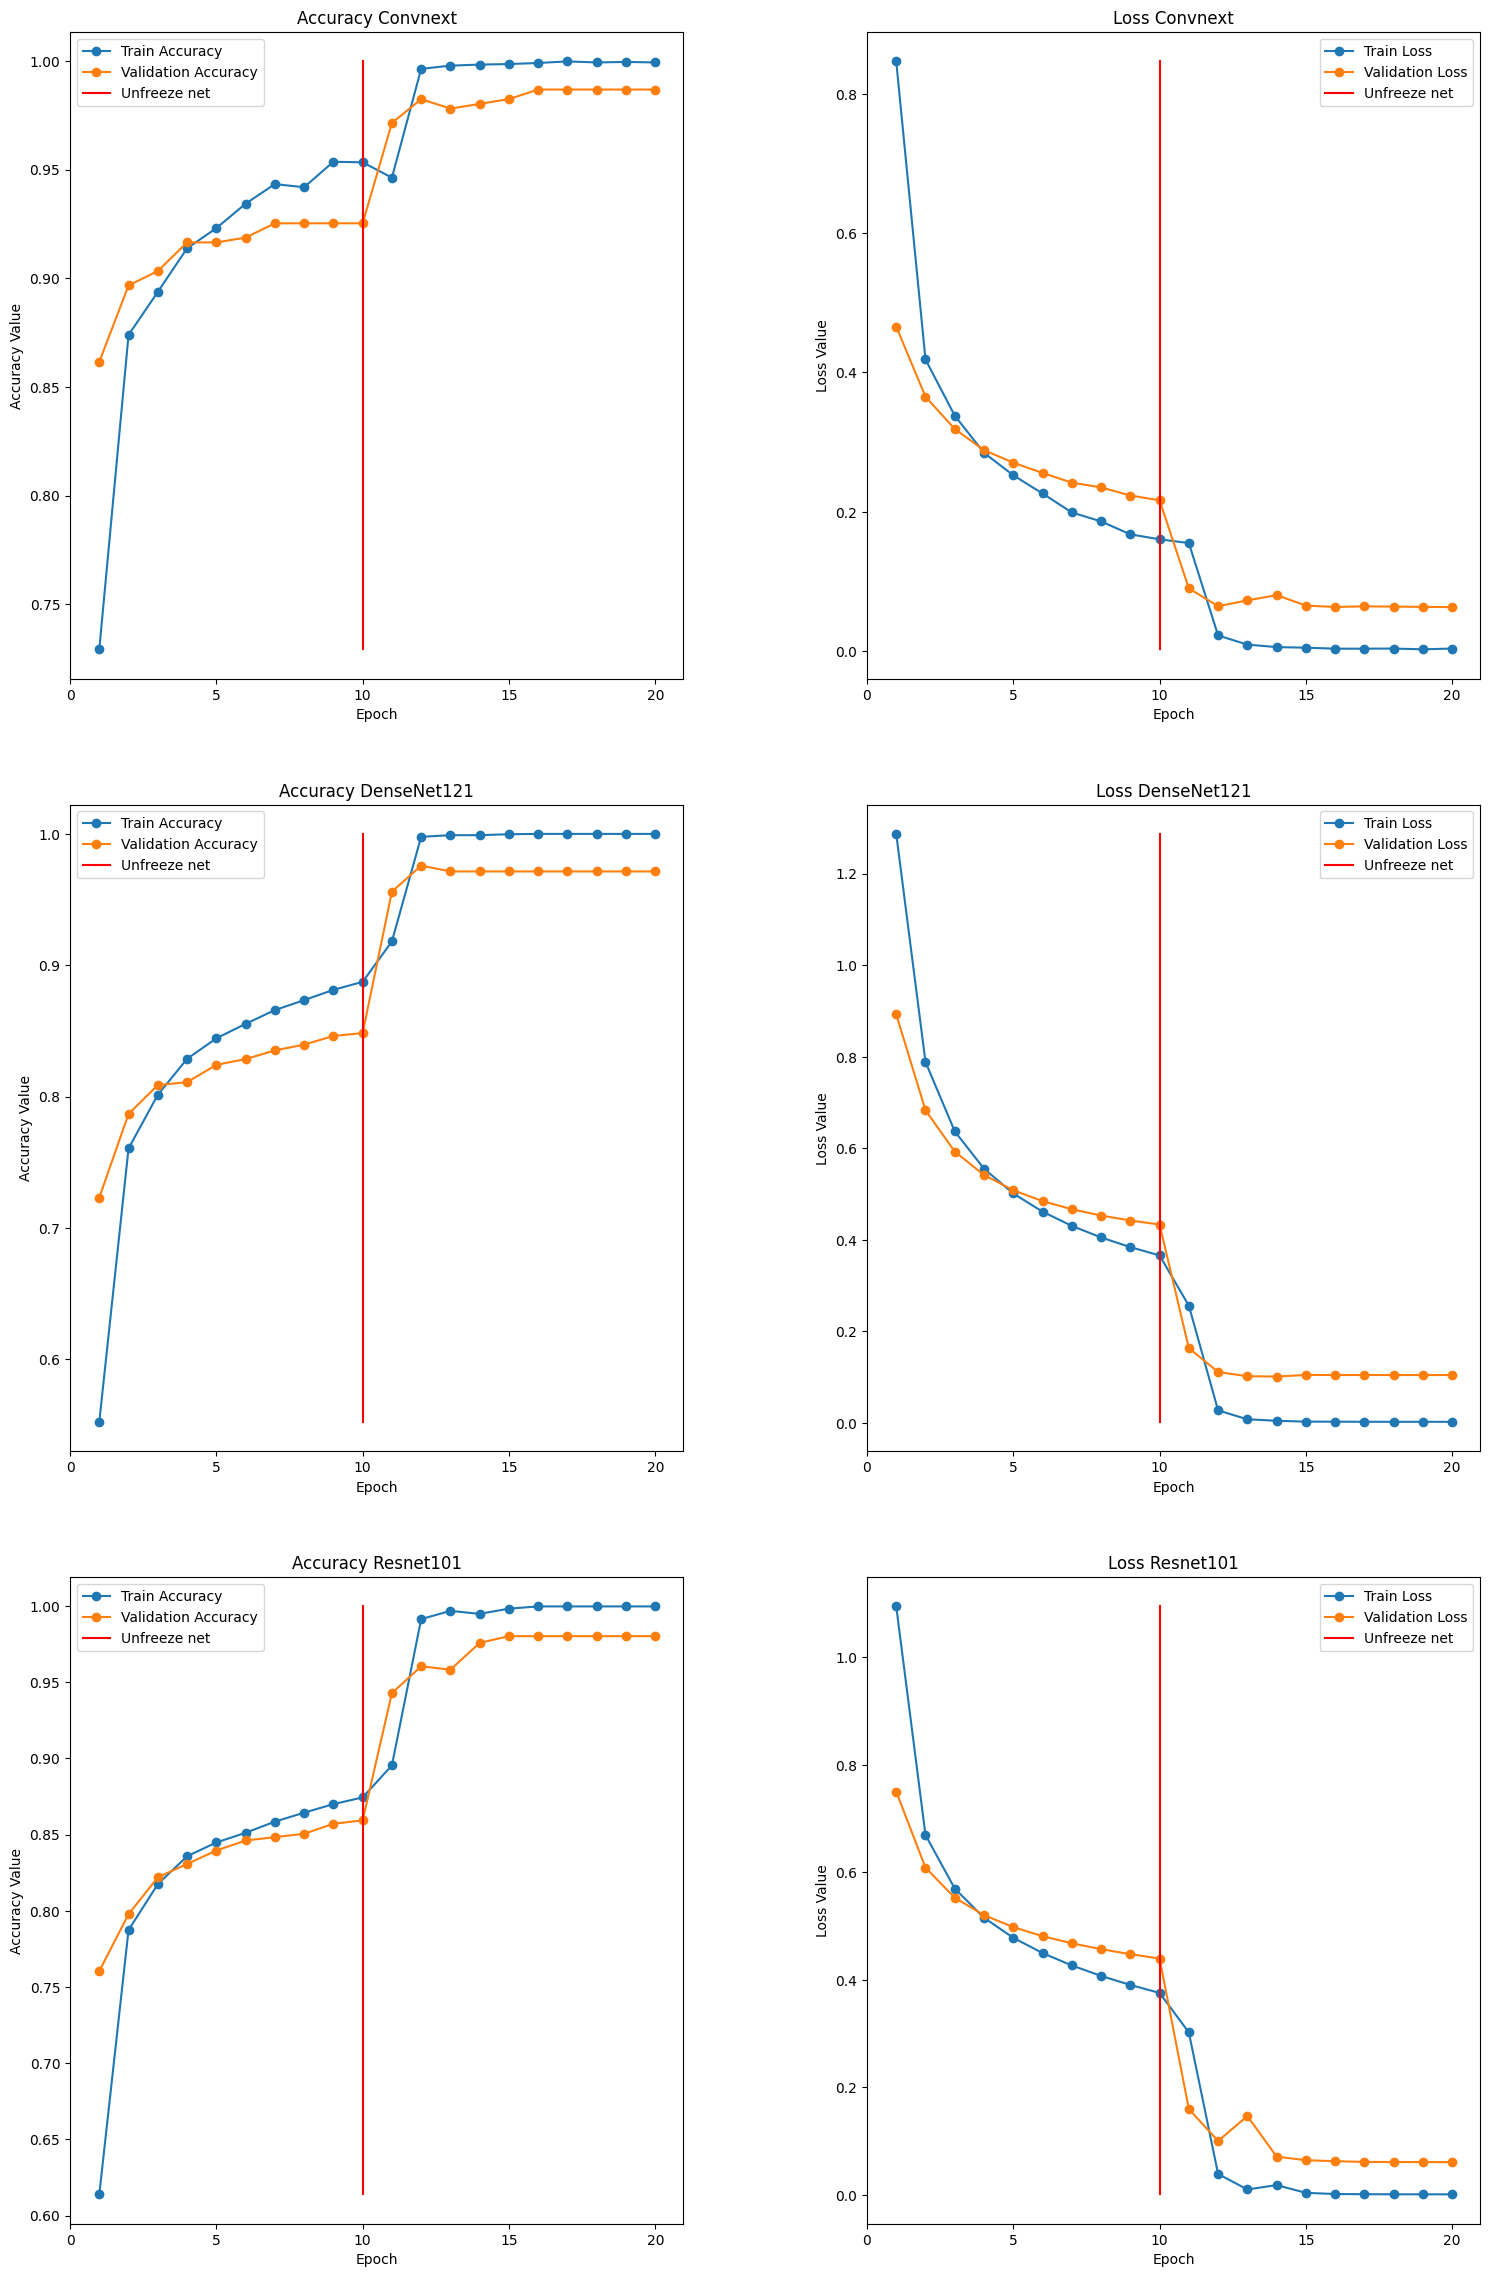

In [26]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
modelname = ['Convnext', 'DenseNet121', 'Resnet101']

i=0

for row in range(3):

  epoch_list = list(range(1,epochs*2+1))

  ax[row][0].plot(epoch_list, accuracies['train'][i:20+i], '-o', label='Train Accuracy')
  ax[row][0].plot(epoch_list, accuracies['val'][i:20+i], '-o', label='Validation Accuracy')
  ax[row][0].plot([epochs for x in range(20)],  np.linspace(min(accuracies['train'][i:20+i]).cpu(), max(accuracies['train'][i:20+i]).cpu(), 20), color='r', label='Unfreeze net')
  ax[row][0].set_xticks(np.arange(0, epochs*2+1, 5))
  ax[row][0].set_ylabel('Accuracy Value')
  ax[row][0].set_xlabel('Epoch')
  ax[row][0].set_title('Accuracy {}'.format(modelname[row]))
  ax[row][0].legend(loc="best")

  ax[row][1].plot(epoch_list, losses['train'][i:20+i], '-o', label='Train Loss')
  ax[row][1].plot(epoch_list, losses['val'][i:20+i], '-o',label='Validation Loss')
  ax[row][1].plot([epochs for x in range(20)], np.linspace(min(losses['train'][i:20+i]), max(losses['train'][i:20+i]), 20), color='r', label='Unfreeze net')
  ax[row][1].set_xticks(np.arange(0, epochs*2+1, 5))
  ax[row][1].set_ylabel('Loss Value')
  ax[row][1].set_xlabel('Epoch')
  ax[row][1].set_title('Loss {}'.format(modelname[row]))
  ax[row][1].legend(loc="best")
  fig.tight_layout()
  fig.subplots_adjust(top=1.5, wspace=0.3)

  i+=20

# 5. Test set Performance

**Model Ensemble Function**

In [27]:
class Ensemble(nn.Module):
    def __init__(self, device):
        super(Ensemble,self).__init__()
        # you should use nn.ModuleList. Optimizer doesn't detect python list as parameters
        self.models = nn.ModuleList(models)
        
    def forward(self, x):
        # it is super simple. just forward num_ models and concat it.
        output = torch.zeros([x.size(0), len(original.classes)]).to(device)
        for model in self.models:
            output += model(x)
        return output

In [28]:
model =  Ensemble(device)

**Test set detection**

In [29]:
def validation_step(batch):
        images,labels = batch
        images,labels = images.to(device),labels.to(device)
        out = model(images)                                      
        loss = F.cross_entropy(out, labels)                    
        acc,preds = accuracy(out, labels)                       
        
        return {'val_loss': loss.detach(), 'val_acc':acc.detach(), 
                'preds':preds.detach(), 'labels':labels.detach()}

In [30]:
def test_prediction(outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()           
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()             
        # combine predictions
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
        # combine labels
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  
        
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}

In [31]:
@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    # perform testing for each batch
    outputs = [validation_step(batch) for batch in test_loader] 
    results = test_prediction(outputs)                          
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))
    
    return results['test_preds'], results['test_labels']

In [32]:
model.to(device)
preds,labels = test_predict(model, loaders['test'])

test_loss: 0.0209, test_acc: 0.9961


Save models

In [33]:
torch.save(densenet121_0, 'densenet121_0.pth')
torch.save(convnext, 'convnext.pth')
torch.save(resnet101, 'resnet101.pth')

# 6. Predict Single


**Standardize and Denormalize**

In [34]:
def norm_out(img):
    
    img = img.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229,0.224,0.225])
    
    img = img*std + mean
        
    return np.clip(img,0,1)

# 7. Metrics and Confusion Matrix

In [35]:
report = classification_report(labels, preds,
                               output_dict=True,
                               target_names=original.classes)
report_df = pd.DataFrame(report).transpose()

In [36]:
pd.set_option("display.max_rows", None)
report_df.head(134)

precision    recall  f1-score     support
cardboard      1.000000  1.000000  1.000000   64.000000
glass          1.000000  1.000000  1.000000  105.000000
metal          1.000000  1.000000  1.000000   86.000000
paper          0.992063  0.992063  0.992063  126.000000
plastic        1.000000  0.990741  0.995349  108.000000
trash          0.944444  1.000000  0.971429   17.000000
accuracy       0.996047  0.996047  0.996047    0.996047
macro avg      0.989418  0.997134  0.993140  506.000000
weighted avg   0.996157  0.996047  0.996071  506.000000

<Figure size 4000x2000 with 0 Axes>

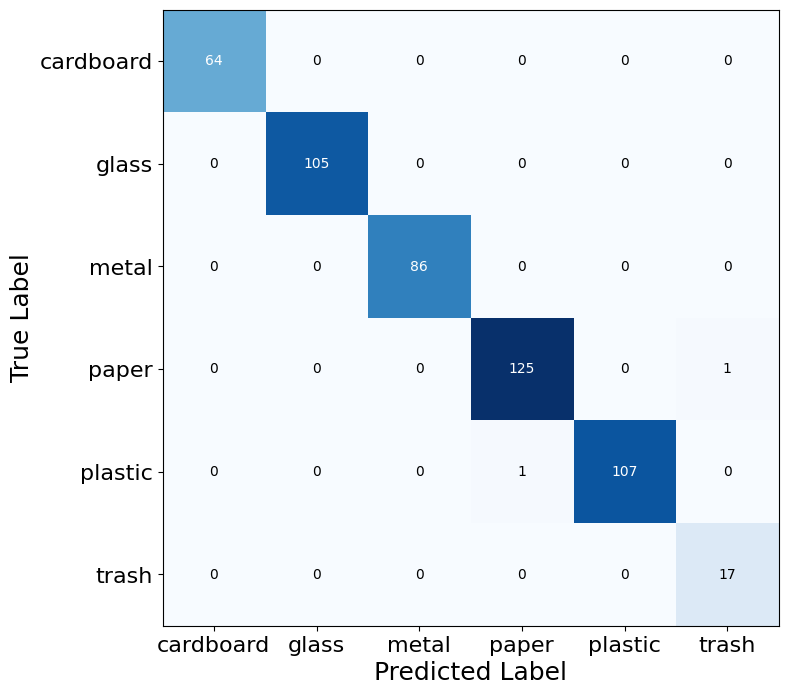

In [37]:
# Plot confusion matrix
cm  = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(len(original.classes)), original.classes, fontsize=16)
plt.yticks(range(len(original.classes)), original.classes, fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()